<a href="https://colab.research.google.com/github/aminnemati96/ML_interpretability/blob/main/Testing_skater.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from skater.core.explanations import Interpretation
from sklearn.preprocessing import LabelEncoder
from pandas_profiling import ProfileReport
from skater.model import InMemoryModel
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np

In [ ]:
import os
os.chdir('Thesis2/01-12')

In [ ]:
df = pd.read_csv("df_final_featured_uncorelated.csv")

In [ ]:
features = [' Source Port', ' Destination Port', ' Protocol', ' Flow Duration',
       ' Total Fwd Packets', 'Total Length of Fwd Packets',
       ' Fwd Packet Length Max', ' Fwd Packet Length Min',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean', ' Flow IAT Mean',
       ' Flow IAT Std', ' Flow IAT Min', ' Bwd IAT Mean', ' Bwd IAT Min',
       'Fwd PSH Flags', ' Fwd Header Length', ' Bwd Header Length',
       'Fwd Packets/s', ' Bwd Packets/s', ' Packet Length Mean',
       ' Packet Length Variance', ' SYN Flag Count', ' ACK Flag Count',
       ' URG Flag Count', ' CWE Flag Count', ' Down/Up Ratio',
       'Init_Win_bytes_forward', ' Init_Win_bytes_backward',
       ' min_seg_size_forward', 'Active Mean', ' Active Std', ' Active Max',
       ' Idle Std', ' Label']
df = df[features]

In [ ]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values
le = LabelEncoder()
y = le.fit_transform(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify=y)

In [ ]:
ann = tf.keras.models.Sequential()
ann.add(tf.keras.Input(shape=(31,)))
ann.add(tf.keras.layers.Dense(units=10, activation='relu'))
ann.add(tf.keras.layers.Dense(units=10, activation='relu'))
ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
ann.fit(X_train, y_train, batch_size = 32, epochs = 10)

Train on 147472 samples
Epoch 1/10
147472/147472 [==============================] - 11s 75us/sample - loss: 9518.3298 - accuracy: 0.9421
Epoch 2/10
147472/147472 [==============================] - 10s 65us/sample - loss: 2605.0116 - accuracy: 0.9745
Epoch 3/10
147472/147472 [==============================] - 9s 59us/sample - loss: 481.6535 - accuracy: 0.9814
Epoch 4/10
147472/147472 [==============================] - 9s 59us/sample - loss: 5896.8954 - accuracy: 0.9771
Epoch 5/10
147472/147472 [==============================] - 8s 58us/sample - loss: 165.5991 - accuracy: 0.9542
Epoch 6/10
147472/147472 [==============================] - 8s 57us/sample - loss: 28.1105 - accuracy: 0.9589
Epoch 7/10
147472/147472 [==============================] - 9s 58us/sample - loss: 774.0596 - accuracy: 0.9680
Epoch 8/10
147472/147472 [==============================] - 9s 59us/sample - loss: 122.9207 - accuracy: 0.9800
Epoch 9/10
147472/147472 [==============================] - 9s 61us/sample - loss: 2

In [ ]:
ann.save("ann.h5")

In [ ]:
y_pred = ann.predict(X_test)
y_pred = (y_pred > 0.5)
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[11187  5681]
 [   43 19957]]


In [ ]:
precision = precision_score(y_true=y_test, y_pred=y_pred)
recall = recall_score(y_true=y_test, y_pred=y_pred)
f1 = f1_score(y_true=y_test, y_pred=y_pred)
print(precision, recall, f1)

0.7784148529526485 0.99785 0.8745782023752137


In [ ]:
interpreter = Interpretation(training_data=X_test, 
                             feature_names=list(df.columns).remove(' Label'))
im_model = InMemoryModel(ann.predict_proba, examples=X_train)

[31/31] features ████████████████████ Time elapsed: 25 seconds

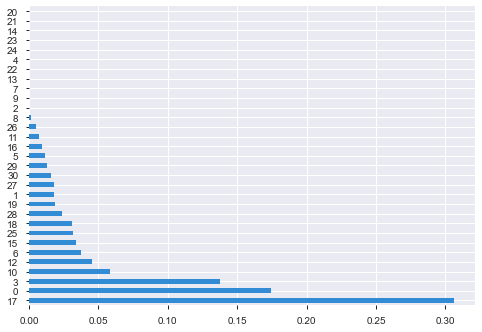

In [ ]:
plots = interpreter.feature_importance.plot_feature_importance(im_model, ascending=True)

In [ ]:
df.columns[21]

' ACK Flag Count'

In [ ]:
test = df.groupby(["_Flow_Duration", "_Destination_Port", "_Label"]).size().reset_index(name="Time")

In [ ]:
test

,_Flow_Duration,_Destination_Port,_Label,Time
0,0,0,BENIGN,1
1,0,53,BENIGN,2
2,0,80,BENIGN,20
3,0,384,DrDoS_UDP,1
4,0,443,BENIGN,708
...,...,...,...,...
160912,119992888,443,BENIGN,1
160913,119995269,443,BENIGN,1
160914,119995583,0,BENIGN,1
160915,119995906,0,BENIGN,1


In [ ]:
df[(df["_Destination_Port"] > 17967) & (df['_Flow_Duration'] < 2)]._Label.value_counts()

DrDoS_UDP    35425
BENIGN        1147
Name: _Label, dtype: int64

In [ ]:
df[(df["_Destination_Port"] == 53) & (df['_Flow_Duration'] < 10)]._Label.value_counts()

BENIGN    143
Name: _Label, dtype: int64

In [ ]:
test[(test["_Label"] == "DrDoS_UDP") & (test['_Destination_Port'] == 21)]

,_Flow_Duration,_Destination_Port,_Label,Time


In [ ]:
test[test["_Label"] == "DrDoS_UDP"].sort_values(by=['Time'], ascending=False)

,_Flow_Duration,_Destination_Port,_Label,Time
42651,3,137,DrDoS_UDP,13
34638,2,137,DrDoS_UDP,8
10146,1,17967,DrDoS_UDP,8
14863,1,27492,DrDoS_UDP,7
29036,1,55574,DrDoS_UDP,7
...,...,...,...,...
49440,48,23679,DrDoS_UDP,1
49439,48,23670,DrDoS_UDP,1
49438,48,23655,DrDoS_UDP,1
49437,48,23612,DrDoS_UDP,1


In [ ]:
df[(df["_Destination_Port"] > 17967) & (df['_Flow_Duration'] < 2) & (df['_Label'] == "BENIGN")]

,_Source_Port,_Destination_Port,_Protocol,_Flow_Duration,_Total_Fwd_Packets,Total_Length_of_Fwd_Packets,_Fwd_Packet_Length_Max,_Fwd_Packet_Length_Min,_Fwd_Packet_Length_Std,Bwd_Packet_Length_Max,...,_CWE_Flag_Count,_Down/Up_Ratio,Init_Win_bytes_forward,_Init_Win_bytes_backward,_min_seg_size_forward,Active_Mean,_Active_Std,_Active_Max,_Idle_Std,_Label
467,443,59612,6,1,2,12.0,6.0,6.0,0.000000,0.0,...,1,0.0,246,-1,20,0.0,0.0,0.0,0.0,BENIGN
801,443,59652,6,1,2,431.0,400.0,31.0,260.922402,0.0,...,0,0.0,33580,-1,20,0.0,0.0,0.0,0.0,BENIGN
1018,443,59637,6,1,2,12.0,6.0,6.0,0.000000,0.0,...,1,0.0,263,-1,20,0.0,0.0,0.0,0.0,BENIGN
1019,443,59635,6,1,2,12.0,6.0,6.0,0.000000,0.0,...,1,0.0,349,-1,20,0.0,0.0,0.0,0.0,BENIGN
1078,443,54925,6,1,2,12.0,6.0,6.0,0.000000,0.0,...,1,0.0,252,-1,20,0.0,0.0,0.0,0.0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203994,80,57627,6,1,2,0.0,0.0,0.0,0.000000,0.0,...,1,0.0,238,-1,20,0.0,0.0,0.0,0.0,BENIGN
204145,80,57622,6,1,2,0.0,0.0,0.0,0.000000,0.0,...,1,0.0,245,-1,20,0.0,0.0,0.0,0.0,BENIGN
204202,80,52003,6,1,2,0.0,0.0,0.0,0.000000,0.0,...,0,0.0,29200,-1,32,0.0,0.0,0.0,0.0,BENIGN
204375,80,51997,6,1,2,0.0,0.0,0.0,0.000000,0.0,...,1,0.0,238,-1,20,0.0,0.0,0.0,0.0,BENIGN
